# TITANIC

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt                        
import seaborn as sns  
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold

In [2]:
#Importação dataset de treino
#Fonte: https://www.kaggle.com/c/titanic/data
train = pd.read_csv('titanic/trains.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#Dados nulos
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Proporção de mortos

Sabemos que a prioridade para salvamento era mulheres e crianças, especialmente se fossem da primeira classe.
Os gráficos e tabela abaixo nos mostram claramente essa tendência, a proporção de homens mortos é muito maior do que a de mulheres, a terceira classe possui uma proporção geral de mortos maior, seguida pela segunda classe.

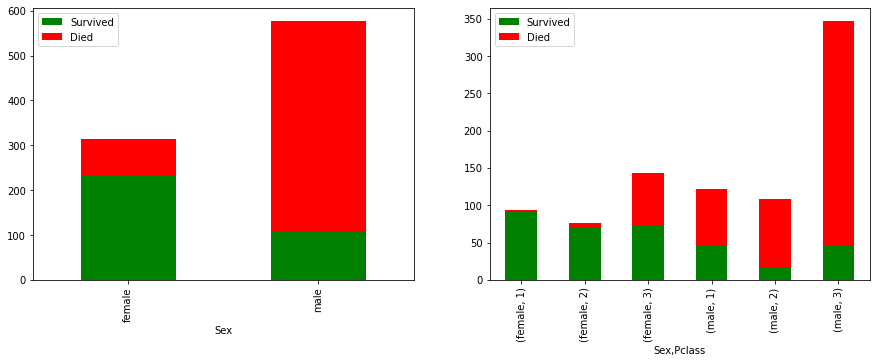

In [5]:
#Criação da coluna 'mortos'
train['Died'] = train['Survived'].replace([0,1],[1,0])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
#Gráfico comparativo entre gêneros
train.groupby('Sex')['Survived','Died'].sum().plot(kind='bar', stacked=True, color=['g','r'], ax=ax1);
#Gráfico comparativo entre gêneros e classes
train.groupby(['Sex','Pclass'])['Survived','Died'].sum().plot(kind='bar', stacked=True, color=['g','r'],ax=ax2);

In [6]:
#Tabela com proporção de mortos
d=train.groupby(['Sex','Pclass'])['Survived','Died'].sum().reset_index()
d['death%']= d.apply(lambda x: (x['Died']/(x['Survived']+x['Died']))*100, axis=1)
d

,Sex,Pclass,Survived,Died,death%
0,female,1,91,3,3.191489
1,female,2,70,6,7.894737
2,female,3,72,72,50.000000
3,male,1,45,77,63.114754
4,male,2,17,91,84.259259
5,male,3,47,300,86.455331


# Idade

Os gráficos de distribuição abaixo monstram uma certa tendência em relação às idades, a terceira classe possui uma concentração de idades próxima a 20 anos, enquanto que as segunda e terceira classes está em 30 e 40 anos.
Um motivo para isso pode ser por conta de que pessoas mais velhas tem mais experiência e possuíram mais tempo para conquistar suas riquezas, os jovens embarcaram em busca do alcance desse objetivo nos EUA.

In [7]:
#Preenchimento de valores nulos da coluna 'Age' através da média em cada gênero e em cada classe
train['Age']=train.groupby(['Pclass','Sex'])['Age'].apply(lambda x: x.fillna(x.median()))

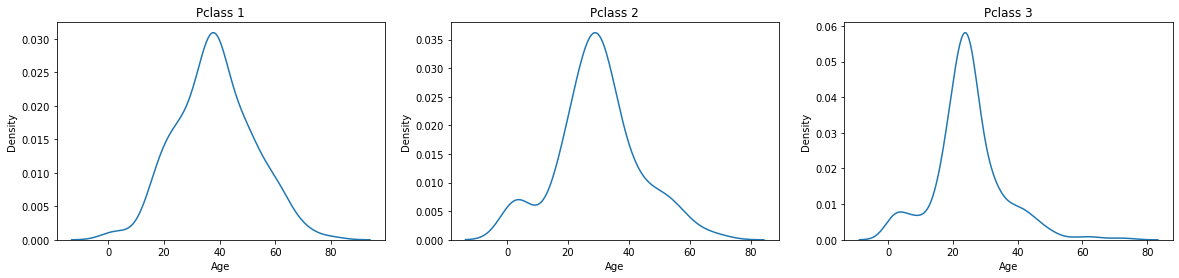

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
#Distribuição de idades 1ª Classe
sns.distplot(train[train['Pclass']==1]['Age'], hist=False, ax=ax1);
ax1.set_title('Pclass 1')
#Distribuição de idades 2ª Classe
sns.distplot(train[train['Pclass']==2]['Age'], hist=False, ax=ax2);
ax2.set_title('Pclass 2')
#Distribuição de idades 3ª Classe
sns.distplot(train[train['Pclass']==3]['Age'],hist=False, ax=ax3);
ax3.set_title('Pclass 3');

In [9]:
#Média de idade por classe
train.groupby('Pclass')['Age'].mean()

Pclass
1    38.270463
2    29.863207
3    24.802281
Name: Age, dtype: float64

In [10]:
#Quantidade de passageiros por classe
train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

# Família

Calculando o tamanho das famílias vemos nas distribuições abaixo que, na terceira classe, esses números estão concentrados entre 1 e 2 membros, equanto nas outras classes famílias com mais de dois membros são mais presentes. Combinada à hipótese abordada anteriormente com as idades, o motivo para isso pode ser que a terceira classe seja composta por passageiros jovens viajando sozinhos ou recém casados com família em formação, almejando um futuro mais próspero. 

In [11]:
#Nova coluna com o cálcula total de membros da família a bordo para cada passageiro
train['FamSize']=train['SibSp'] + train['Parch'] + 1

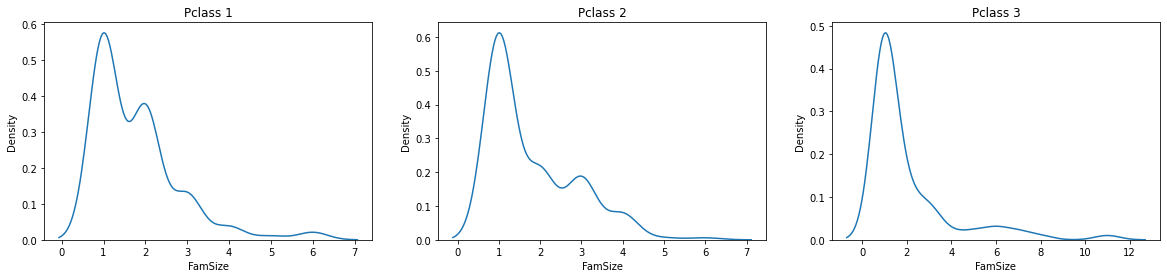

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
#Distribuição de tamanho da família 1ª Classe
sns.distplot(train[train['Pclass']==1]['FamSize'], hist=False, ax=ax1);
ax1.set_title('Pclass 1')
#Distribuição de tamanho da família 2ª Classe
sns.distplot(train[train['Pclass']==2]['FamSize'], hist=False, ax=ax2);
ax2.set_title('Pclass 2')
#Distribuição de tamanho da família 3ª Classe
sns.distplot(train[train['Pclass']==3]['FamSize'], hist=False, ax=ax3);
ax3.set_title('Pclass 3');

# Nomes(título social)

Cada nome de passageiro é classificado com um título indicando sua posição social(nobres ou comuns). Sabendo-se que sim, as pessoas da nobreza tinham prioridade no momento do salvamento, vamos observar essa informação.

In [13]:
#Loop para extrair dos nomes somente o título social
title = []
for i in train['Name']:
    title.append(i.split(', ')[1].split('.')[0])
train['Title'] = title
train['title'] = title
dic={
    'Mr':1,
    'Mrs':2,
    'Miss':3,
    'Master':4,
    'Don':5,
    'Rev':6,
    'Dr':6,
    'Mme':2,
    'Ms':2,
    'Major':6,
    'Lady':5,
    'Sir':5,
    'Mlle':3,
    'Col':6,
    'Capt':6,
    'the Countess':5,
    'Jonkheer':5
}
train['Title'] = train['Title'].map(dic)

In [14]:
#Resultado
train[['title','Title']].head(10)

,title,Title
0,Mr,1
1,Mrs,2
2,Miss,3
3,Mrs,2
4,Mr,1
5,Mr,1
6,Mr,1
7,Master,4
8,Mrs,2
9,Mrs,2


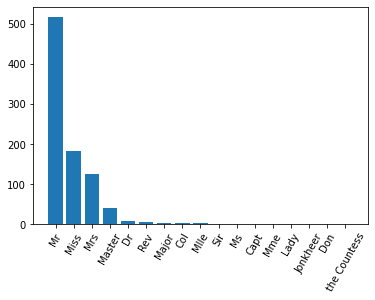

In [15]:
r = train.groupby(['title']).count().reset_index().sort_values('PassengerId', ascending=False)
plt.xticks(rotation=60)
plt.bar(r['title'],r['PassengerId']);

# Cabines

Sabe-se que o iceberg atingiu a parte inferior do navio, logo as cabines mais abaixo como na imagem foram as primeiras as serem inundadas. As pessoas que estavam nestas cabines conseguiram sair a tempo?
<div>
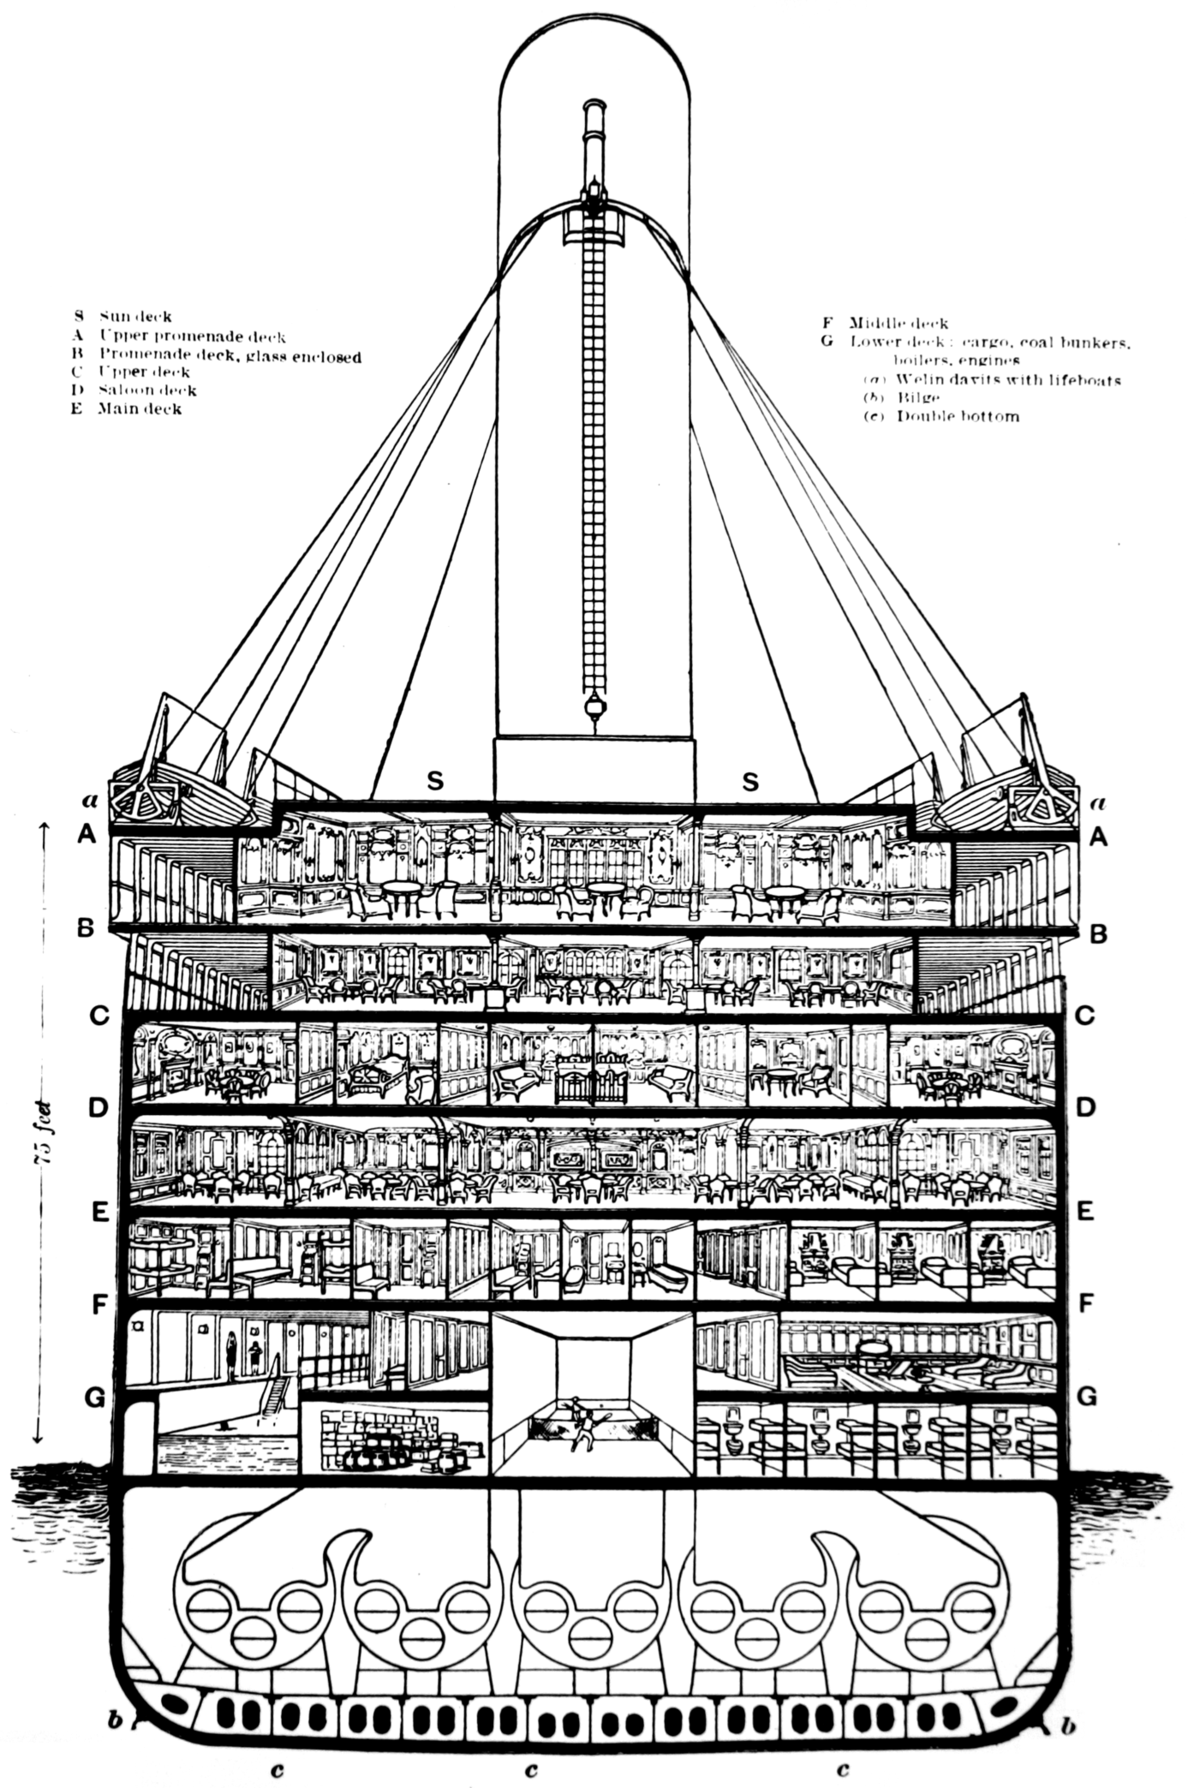
</div>

In [16]:
#Criação de uma variável numérica indicando o andar da cabine do passageiro.
train.update(train['Cabin'].fillna('N'))
newcab=[]
for i in train['Cabin']:
    newcab.append(i[0])
train['Cab'] = newcab
dic={
    'A':1,
    'B':2,
    'C':3,
    'D':4,
    'E':5,
    'F':6,
    'G':7,
    'N':8,
    'T':8
}
train['Cab'] = train['Cab'].map(dic)

In [17]:
#Resultado
train[['Cab']].head()

,Cab
0,8
1,3
2,8
3,3
4,8


In [18]:
#Preenchimento dos valores nulos da variável 'Embarked'
train['Embarked']=train['Embarked'].fillna('S')

# Validação

In [19]:
#Seleção das variáveis numéricas
x = train[['Pclass','Sex','Age','SibSp','Fare','Embarked','FamSize','Cab','Title']]
#variável target
y = train['Survived']
x.head(3)

,Pclass,Sex,Age,SibSp,Fare,Embarked,FamSize,Cab,Title
0,3,male,22.0,1,7.2500,S,2,8,1
1,1,female,38.0,1,71.2833,C,2,3,2
2,3,female,26.0,0,7.9250,S,1,8,3


O **RepeatedKFold** será usado na validação para ajudar a encontrar os algoritmos que possuem um melhor desempenho nesse caso.

In [20]:
#algoritmos das predições
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

resulEx = []
resulKN = []
resulLR = []
resulGa = []
resulRF = []

scaler = StandardScaler()
rkf = RepeatedKFold(n_splits=2, n_repeats=10, random_state=10)

for linet, linev in rkf.split(x):
    print(linet.shape[0])
    print(linev.shape[0])
    
    xtrain, xvalid = x.iloc[linet], x.iloc[linev]
    ytrain, yvalid = y.iloc[linet], y.iloc[linev]
    
    #Encoding dos valores categóricos
    xtrain = pd.get_dummies(xtrain)
    xvalid = pd.get_dummies(xvalid)
    
    #Escalonamento das variáveis
    xtrain = scaler.fit_transform(xtrain)
    xvalid = scaler.fit_transform(xvalid)
    
    #ExtraTreesClassifier()
    estimator = ExtraTreesClassifier(n_estimators=500,bootstrap=True)
    estimator.fit(xtrain,ytrain)

    #KNeighborsClassifier()
    estimator1 = KNeighborsClassifier()
    estimator1.fit(xtrain,ytrain)

    #GaussianNB()
    estimator2 = GaussianNB()
    estimator2.fit(xtrain,ytrain)
    
    #LogisticRegression()
    estimator3 = LogisticRegression()
    estimator3.fit(xtrain,ytrain)
    
    #RandomForest()
    estimator4 = RandomForestClassifier()
    estimator4.fit(xtrain,ytrain)
    
    p = estimator.predict(xvalid)
    p1 = estimator1.predict(xvalid)
    p2 = estimator2.predict(xvalid)
    p3 = estimator3.predict(xvalid)
    p4 = estimator4.predict(xvalid)
    
    acc = np.mean(yvalid == p)
    acc1 = np.mean(yvalid == p1)
    acc2 = np.mean(yvalid == p2)
    acc3 = np.mean(yvalid == p3)
    acc4 = np.mean(yvalid == p4)
    
    resulEx.append(acc)
    resulKN.append(acc1)
    resulGa.append(acc2)
    resulLR.append(acc3)
    resulRF.append(acc4)
    print('Acc', acc)
    print('Acc1', acc1)
    print('Acc2', acc2)
    print('Acc3', acc3)
    print('Acc4', acc4)

np.mean(resulEx), np.mean(resulKN), np.mean(resulGa), np.mean(resulLR ), np.mean(resulRF)

445
446
Acc 0.8228699551569507
Acc1 0.820627802690583
Acc2 0.7825112107623319
Acc3 0.8161434977578476
Acc4 0.8071748878923767
446
445
Acc 0.8
Acc1 0.7955056179775281
Acc2 0.7707865168539326
Acc3 0.7730337078651686
Acc4 0.7842696629213484
445
446
Acc 0.8161434977578476
Acc1 0.7982062780269058
Acc2 0.7959641255605381
Acc3 0.8139013452914798
Acc4 0.8094170403587444
446
445
Acc 0.7910112359550562
Acc1 0.8067415730337079
Acc2 0.7617977528089888
Acc3 0.7887640449438202
Acc4 0.7775280898876404
445
446
Acc 0.8139013452914798
Acc1 0.8116591928251121
Acc2 0.7713004484304933
Acc3 0.7959641255605381
Acc4 0.8183856502242153
446
445
Acc 0.8
Acc1 0.8112359550561797
Acc2 0.7887640449438202
Acc3 0.7955056179775281
Acc4 0.802247191011236
445
446
Acc 0.8094170403587444
Acc1 0.8026905829596412
Acc2 0.8094170403587444
Acc3 0.8004484304932735
Acc4 0.7937219730941704
446
445
Acc 0.7730337078651686
Acc1 0.8067415730337079
Acc2 0.7573033707865169
Acc3 0.8067415730337079
Acc4 0.7707865168539326
445
446
Acc 0.80

(0.8084073159671487,
 0.8107716531465712,
 0.7818111049528896,
 0.7997682269360608,
 0.7967297324532676)

# Treinamento e Teste

In [21]:
#Importação do dataset de teste
test = pd.read_csv('titanic/test.csv')

In [22]:
#Aplicação no dataset de teste de todo o processamento de dados feito anteriormente

#Variável com tamanho da família
test['FamSize']=test['SibSp'] + test['Parch'] + 1
#Preechimento de valores nulos
test['Age']=test.groupby(['Pclass','Sex'])['Age'].apply(lambda x: x.fillna(x.median()))
test['Fare']=test.groupby(['Pclass','Sex'])['Fare'].apply(lambda x: x.fillna(x.mean()))

#Título social
title = []
for i in test['Name']:
    title.append(i.split(', ')[1].split('.')[0])
test['Title'] = title
test['title'] = title
dic={
    'Mr':1,
    'Mrs':2,
    'Miss':3,
    'Master':4,
    'Don':5,
    'Rev':6,
    'Dr':6,
    'Mme':2,
    'Ms':2,
    'Major':6,
    'Lady':5,
    'Sir':5,
    'Mlle':3,
    'Col':6,
    'Capt':6,
    'the Countess':5,
    'Jonkheer':5
}
test['Title'] = test['Title'].map(dic).fillna(0)

#Numeração das cabines
test.update(test['Cabin'].fillna('N'))
newcab=[]
for i in test['Cabin']:
    newcab.append(i[0])
test['Cab'] = newcab
dic={
    'A':1,
    'B':2,
    'C':3,
    'D':4,
    'E':5,
    'F':6,
    'G':7,
    'N':8,
    'T':8
}
test['Cab'] = test['Cab'].map(dic)

In [23]:
#Importação dos valores reais da variável a ser prevista
yt = pd.read_csv('titanic/gender_submission.csv')
yt=yt['Survived']

Na fase de validação foi visto que os algoritmos obtiveram resultados próximos, o teste será feito com todos.

In [24]:
x = train[['Pclass','Sex','Age','SibSp','Fare','Embarked','FamSize','Cab','Title']]
y = train['Survived']
xt = test[['Pclass','Sex','Age','SibSp','Fare','Embarked','FamSize','Cab','Title']]

#Encoding dos valores categóricos
x = pd.get_dummies(x)
xt = pd.get_dummies(xt)

#Escalonamento das variáveis
x = scaler.fit_transform(x)
xt = scaler.fit_transform(xt)

#ExtraTreesClassifier()
estimator = ExtraTreesClassifier(n_estimators=500,bootstrap=True)
estimator.fit(x,y)

#KNeighborsClassifier()
estimator1 = KNeighborsClassifier()
estimator1.fit(x,y)

#GaussianNB()
estimator2 = GaussianNB()
estimator2.fit(x,y)

#LogisticRegression()
estimator3 = LogisticRegression()
estimator3.fit(x,y)

#RandomForest()
estimator4 = RandomForestClassifier()
estimator4.fit(x,y)

p = estimator.predict(xt)
p1 = estimator1.predict(xt)
p2 = estimator2.predict(xt)
p3 = estimator3.predict(xt)
p4 = estimator4.predict(xt)

acc = np.mean(yt == p)
acc1 = np.mean(yt == p1)
acc2 = np.mean(yt == p2)
acc3 = np.mean(yt == p3)
acc4 = np.mean(yt == p4)

from sklearn.metrics import accuracy_score,confusion_matrix
print('acc_ExtraTreesClassifier :',accuracy_score(y_true = yt.values, y_pred=p))
print('acc_KNeighborsClassifier:',accuracy_score(y_true = yt.values, y_pred=p1))
print('acc_GaussianNB:',accuracy_score(y_true = yt.values, y_pred=p2))
print('acc_LogisticRegression:',accuracy_score(y_true = yt.values, y_pred=p3))
print('acc_RandomForestClassifier:',accuracy_score(y_true = yt.values, y_pred=p4))

acc_ExtraTreesClassifier : 0.8349282296650717
acc_KNeighborsClassifier: 0.8492822966507177
acc_GaussianNB: 0.9114832535885168
acc_LogisticRegression: 0.9282296650717703
acc_RandomForestClassifier: 0.8277511961722488


O algoritmo com melhor desempenho foi **LogisticRegression** com **92,82** % de acerto.